In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils

In [2]:
import numpy as np
import scipy.misc
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import json

In [3]:
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images
    i.e. takes images with multiple channels and average over channels to finally give one channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

In [4]:
def normalize(image):
    
    """
    Returns Variable after unsqueezing the first dimension.
    """
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    image = Variable(preprocess(image).unsqueeze(0).cuda(), requires_grad=True)
    return image

"""
preprocess does the same as normalize, but it returns tensor, not Variable
"""

normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])


def predict(model, image):
    _, index = model(image).data[0].max(0)
    return str(index[0]), labels[str(index[0])][1]
    
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.axis('off')
    print("Image loaded successfully")
    return image

def normalize_inception(image):
    
    """
    Returns Variable after unsqueezing the first dimension.
    """
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    normalize
    ])
    image = Variable(preprocess(image).unsqueeze(0).cuda(), requires_grad=True)
    return image

In [ ]:
vgg = models.vgg16(pretrained=True)
vgg.cuda()
vgg.eval()

In [ ]:
inception = models.inception_v3(pretrained=True)
inception.cuda()
inception.eval()

In [ ]:
resnet = models.resnet152(pretrained=True)
resnet.cuda()
resnet.eval()

In [8]:
labels = json.load(open('labels/imagenet_class_index.json'))

In [9]:
modulelist_conv = list(vgg.features.modules())
modulelist_fc = list(vgg.classifier.modules())

Image loaded successfully
Image loaded successfully


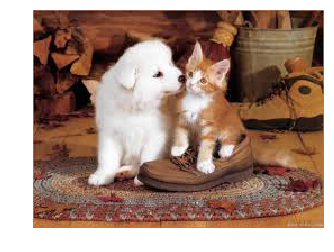

In [10]:
# Load Image
image1 = load_image('images/doggo-dd.jpg')
image2 = load_image('images/dogcat2.jpg')

# Occlusion Heatmap

In [11]:
def make_heatmap(image, true_class, k=8, stride=8): 
    """
    Input image is of size (1, c, w, h) typically (1, 3, 224, 224) for vgg16
    true_class is a number corresponding to imagenet classes
    k is the filter size (c, k, k)
    """
    image = normalize(image)
    heatmap = torch.zeros(int(((image.shape[2]-k)/stride)+1), int(((image.shape[3]-k)/stride)+1))
    image = image.data

    i = 0
    a = 0
    while i<=image.shape[3]-k:
        j = 0 
        b = 0
        while j<=image.shape[2]-k:
            h_filter = torch.ones(image.shape)
            h_filter[:,:,j:j+k, i:i+k] = 0
            temp_image = Variable((image.cuda() * h_filter.cuda()).cuda())
            temp_softmax = vgg(temp_image)
            temp_softmax = torch.nn.functional.softmax(temp_softmax).data[0]
            heatmap[a][b] = temp_softmax[true_class]
            j += stride
            b += 1
        print(a)
        i += stride
        a += 1
    
    image = image.squeeze()
    
    true_image = image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    # Un-Normalize image
    true_image = true_image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()
    
    # Plot both images
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)
    
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off') 
    
    # Normalize heatmap
#     heatmap = heatmap - heatmap.min()
#     heatmap = heatmap/heatmap.max()
    heatmap = resize(heatmap.numpy(), (224,224), preserve_range=True, mode='edge')
    
#     print(type(heatmap))
#     print(np.asarray(heatmap).max())
    
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(heatmap, cmap='hot')
    plt.title('Heatmap')
    plt.axis('off') 
    
    return heatmap

/home/sarthak/.virtualenvs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0
1
2
3
4
5
6


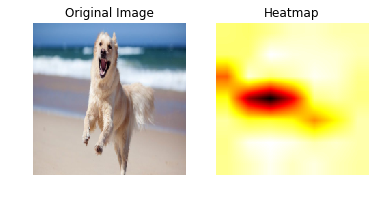

In [11]:
occ_heatmap = make_heatmap(image1, 207, k=32, stride=32)

# Saliency Maps

In [43]:
def saliency_map(model, input, label):
    
    if (isinstance(model, models.Inception3)):
        input = normalize_inception(input)
    else:
        input = Variable(preprocess(input).unsqueeze(0).cuda(), requires_grad=True)

    output = model.forward(input)
    model.zero_grad()

    output[0][label].backward()

    grads = input.grad.data.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.cpu().numpy(), axis=2)
    
    grads -= grads.min()
    grads /= grads.max()
    
    grads *= 255
    grads = grads.astype(int)
    
    true_image = input.data
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image)

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)


    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads, cmap='hot')
    plt.axis('off') 
    plt.title('Saliency Map')
    
    return grads

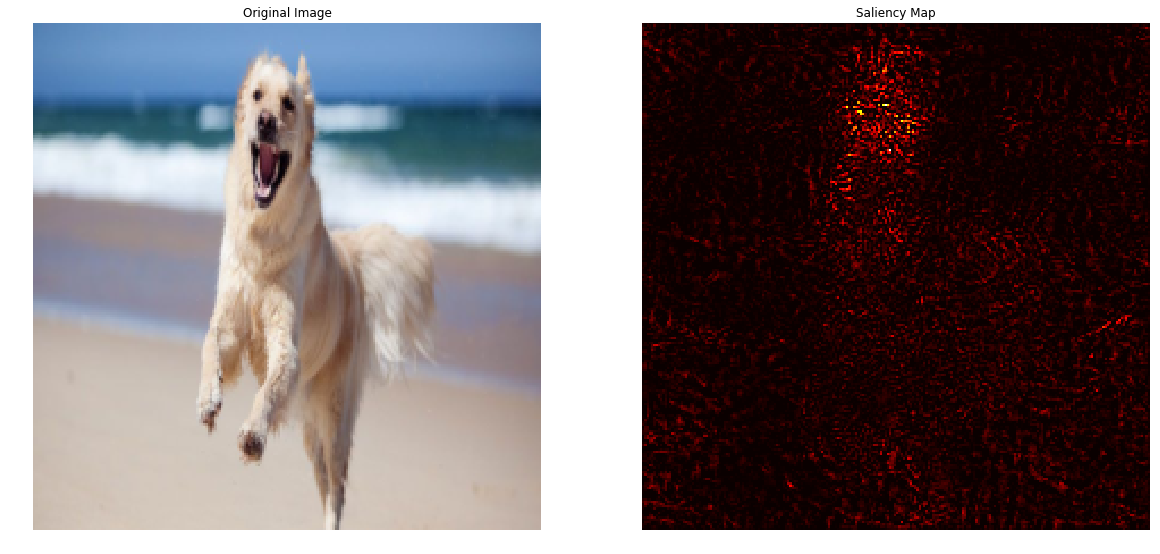

In [45]:
sal_map = saliency_map(vgg, image1, 207)

In [46]:
def saliency_map_guided(model, input, label, plot=True):
    
    if (isinstance(model, models.Inception3)):
        input = normalize_inception(input)
    else:
        input = Variable(preprocess(input).unsqueeze(0).cuda(), requires_grad=True)
    try:
        h = [0]*len(list(model.modules()))

        def hookfunc(module, gradInput, gradOutput):
            return tuple([(None if g is None else g.clamp(min=0)) for g in gradInput])

        for j, i in enumerate(list(model.modules())):
            h[j] = i.register_backward_hook(hookfunc)

        output = model.forward(input)
        model.zero_grad()


        output[0][label].backward()

        for i in range(len(list(model.modules()))):
            h[i].remove()
    except Exception as e:
        print(e)
        for i in range(len(list(model.modules()))):
            h[i].remove()
        
    grads = input.grad.data.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.cpu().numpy(), axis=2)
    
    grads -= grads.min()
    grads /= grads.max()
    
    grads *= 255
    grads = grads.astype(int)
    
    true_image = input.data
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image)

    if plot:
        fig = plt.figure()
        plt.rcParams["figure.figsize"] = (20, 20)


        a = fig.add_subplot(1,2,1)
        imgplot = plt.imshow(true_image)
        plt.title('Original Image')
        plt.axis('off') 

        a = fig.add_subplot(1,2,2)
        imgplot = plt.imshow(grads, cmap='hot')
        plt.axis('off') 
        plt.title('Guided Backprop')
    
    return grads

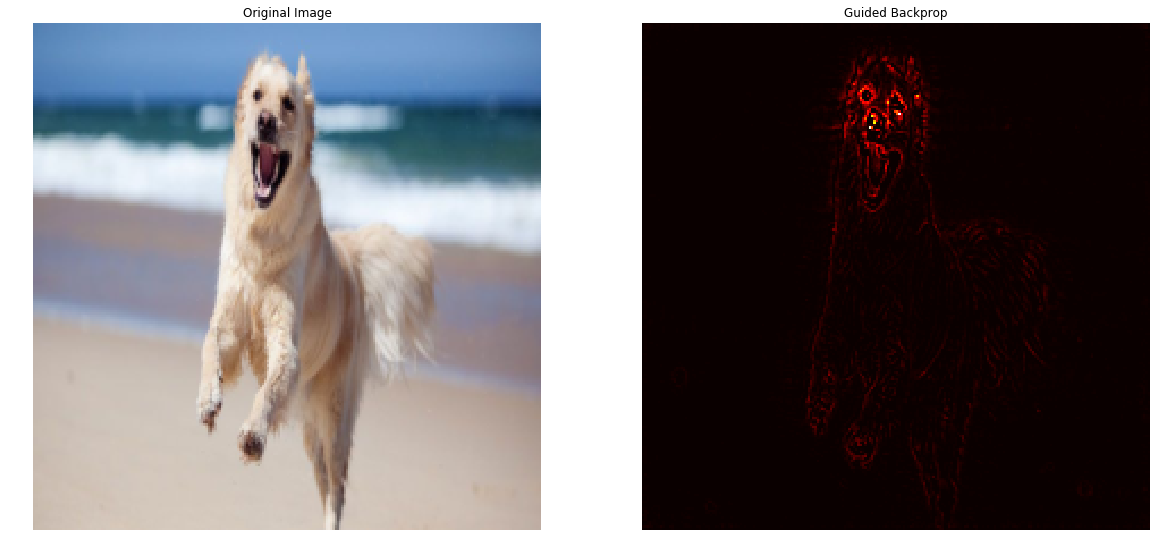

In [47]:
sal_map = saliency_map_guided(vgg, image1, 207)

# SmoothGrad

In [48]:
def smooth_grad(model, input, label, x=10, percent_noise=10):
    """
    The apparent noise one sees in a sensitivity map may be due to 
    essentially meaningless local variations in partial derivatives.
    After all, given typical training techniques there is no reason to expect derivatives to vary smoothly.
    """
    tensor_input = torch.from_numpy(np.array(input)).type(torch.cuda.FloatTensor) # input is now of shape (w,h,c)
    # x is the sample size
    if (isinstance(model, models.Inception3)):
            final_grad = torch.zeros((1,3,299,299)).cuda()
    else:
        final_grad = torch.zeros((1,3,224,224)).cuda()    
        
    for i in range(x):
        print('Sample:', i+1)
        temp_input = tensor_input
        # According to the paper, noise level corrresponds to stddev/(xmax-xmin). Hence stddev = noise_percentage * (max-min) /100
        noise = torch.from_numpy(np.random.normal(loc=0, scale=(percent_noise/100) * (tensor_input.max() - tensor_input.min()), size=temp_input.shape)).type(torch.cuda.FloatTensor)
        temp_input = (temp_input + noise).cpu().numpy()
        temp_input = Image.fromarray(temp_input.astype(np.uint8))
        if (isinstance(model,models.Inception3)):
            temp_input = normalize_inception(temp_input)
        else:
            temp_input = Variable(preprocess(temp_input).unsqueeze(0).cuda(), requires_grad=True)

        output = model.forward(temp_input)
        model.zero_grad()
        output[0][label].backward()
        final_grad += temp_input.grad.data
    
    grads = final_grad/x
    grads = grads.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.cpu().numpy(), axis=2)
    
    grads -= grads.min()
    grads /= grads.max()
    
    grads *= 255
    grads = grads.astype(int)

    
    true_image = normalize(input)
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image.data)

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)


    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads, cmap='hot')
    plt.axis('off')  
    plt.title('SmoothGrad, Noise: ' + str(percent_noise) + '%, ' + 'Samples: ' + str(x))
    
    return grads

Sample: 1
Sample: 2
Sample: 3
Sample: 4
Sample: 5
Sample: 6
Sample: 7
Sample: 8
Sample: 9
Sample: 10


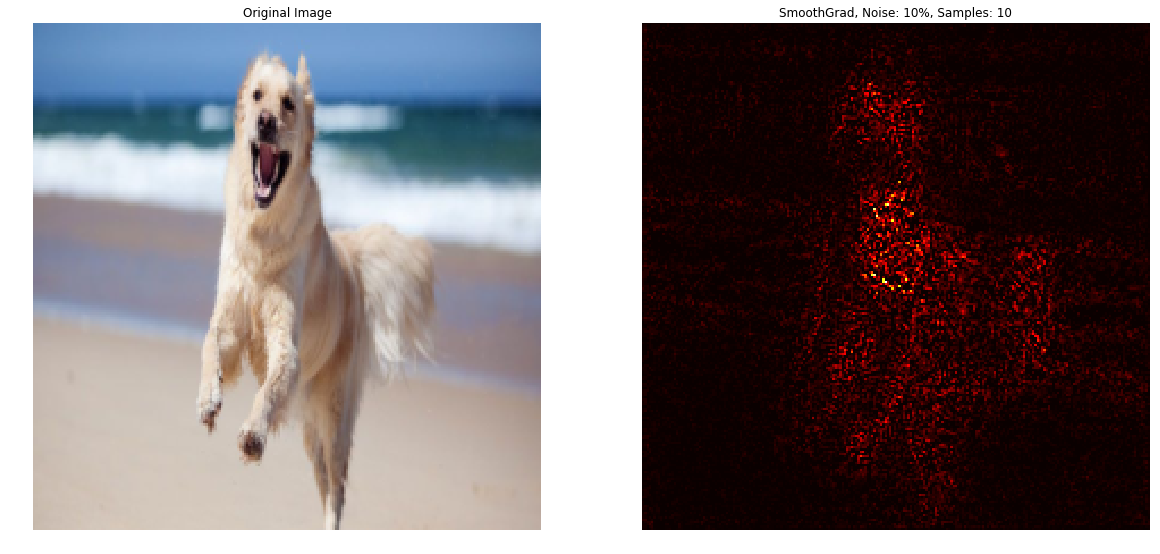

In [49]:
sg = smooth_grad(vgg, image1, 207)

In [50]:
def smooth_grad_guided(model, input, label, x=10, percent_noise=10):
    """
    The apparent noise one sees in a sensitivity map may be due to 
    essentially meaningless local variations in partial derivatives.
    After all, given typical training techniques there is no reason to expect derivatives to vary smoothly.
    """
    tensor_input = torch.from_numpy(np.array(input)).type(torch.cuda.FloatTensor) # input is now of shape (w,h,c)
    # x is the sample size
    if (isinstance(model, models.Inception3)):
            final_grad = torch.zeros((1,3,299,299)).cuda()
    else:
        final_grad = torch.zeros((1,3,224,224)).cuda() 
        
    h = [0]*len(list(model.modules()))

    def hookfunc(module, gradInput, gradOutput):
        return tuple([(None if g is None else g.clamp(min=0)) for g in gradInput])

    for j, i in enumerate(list(model.modules())):
        h[j] = i.register_backward_hook(hookfunc)
        
    for i in range(x):
        print('Sample:', i+1)
        temp_input = tensor_input
        # According to the paper, noise level corrresponds to stddev/(xmax-xmin). Hence stddev = noise_percentage * (max-min) /100
        noise = torch.from_numpy(np.random.normal(loc=0, scale=(percent_noise/100) * (tensor_input.max() - tensor_input.min()), size=temp_input.shape)).type(torch.cuda.FloatTensor)
        temp_input = (temp_input + noise).cpu().numpy()
        temp_input = Image.fromarray(temp_input.astype(np.uint8))
        if (isinstance(model, models.Inception3)):
            temp_input = normalize_inception(temp_input)
        else:
            temp_input = Variable(preprocess(temp_input).unsqueeze(0).cuda(), requires_grad=True)

        output = model.forward(temp_input)
        model.zero_grad()
        output[0][label].backward()
        final_grad += temp_input.grad.data
        
    for i in range(len(list(model.modules()))):
        h[i].remove()
    
    grads = final_grad/x
    grads = grads.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.cpu().numpy(), axis=2)
    
    grads -= grads.min()
    grads /= grads.max()
    
    grads *= 255
    grads = grads.astype(int)
    
    true_image = normalize(input)
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image.data)

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)


    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads, cmap='hot')
    plt.axis('off')  
    plt.title('Guided SmoothGrad, Noise: ' + str(percent_noise) + '%, ' + 'Samples: ' + str(x))
    
    return grads

Sample: 1
Sample: 2
Sample: 3
Sample: 4
Sample: 5
Sample: 6
Sample: 7
Sample: 8
Sample: 9
Sample: 10


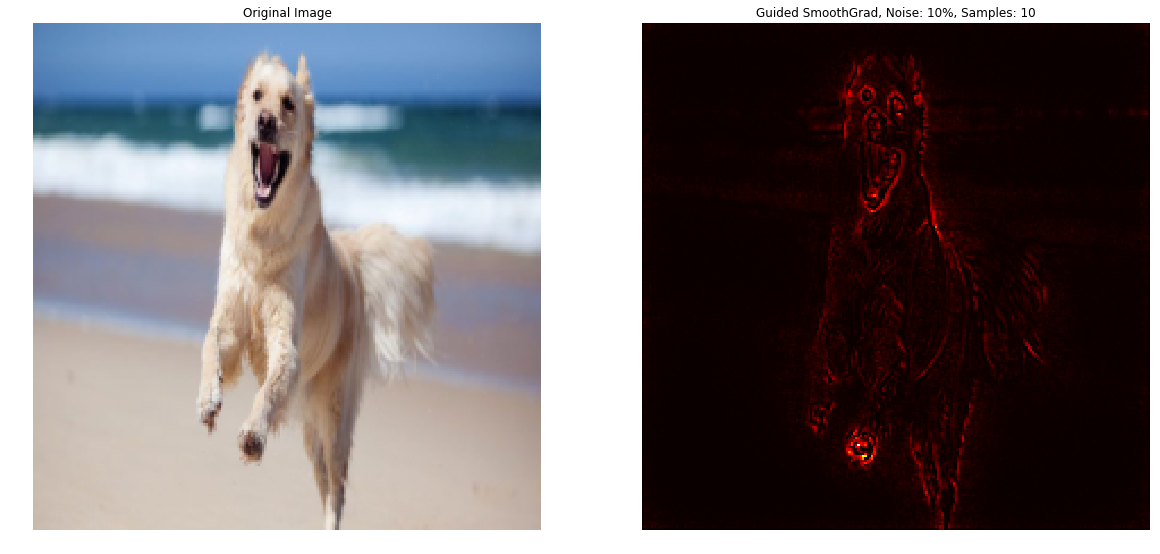

In [51]:
x = smooth_grad_guided(vgg, image1, 207)

# GradCAM

In [52]:
"""
Calculate gradient of class score with each of last conv layer filters.
Calculate weighted sum of gradients and filters to finally obtain a map of size equal to size of filters.
Apply ReLU.
Resize map to input size.
Scale to [0,1] i.e. -min followed by /max
"""

'\nCalculate gradient of class score with each of last conv layer filters.\nCalculate weighted sum of gradients and filters to finally obtain a map of size equal to size of filters.\nApply ReLU.\nResize map to input size.\nScale to [0,1] i.e. -min followed by /max\n'

In [53]:
def gradcam(model, input, label, plot=True):
    rs = transforms.Resize((224,224))
    if isinstance(model, models.Inception3):
        rs = transforms.Resize((299,299))
        last_conv = model.Mixed_7c.branch_pool
    elif isinstance(model, models.VGG):
        last_conv = model.features[-3]
    elif isinstance(model, models.ResNet):
        last_conv = model.layer4[-1].conv3
        
    pre_image = rs(input)
    if isinstance(model, models.Inception3):
        input = normalize_inception(input)
    else:
        input = normalize(input)
        
    global gcdata
    global gcgrads

    def bhook(module, gradInputs, gradOutputs):
        global gcgrads
        gcgrads = gradOutputs

    def fhook(module, input, output):
        global gcdata
        gcdata = output
        
    hb = last_conv.register_backward_hook(bhook)
    hf = last_conv.register_forward_hook(fhook)
        
    out = model(input)
    model.zero_grad()
    out[0, label].backward()
    
    hb.remove()
    hf.remove()
    
    gcdata = gcdata[0]
    gcgrads = gcgrads[0].squeeze()
    
    gcgrads = gcgrads.mean(dim=2, keepdim=True)
    gcgrads = gcgrads.mean(dim=1, keepdim=True)
    
    gcdata = gcdata.mul(gcgrads)
    gcdata = gcdata.sum(dim=0, keepdim=True)
    
    gcdata = gcdata.clamp(min=0)
    
    gcdata -= gcdata.min()
    gcdata /= gcdata.max()
    
    toi = transforms.ToPILImage()
    
    gcdata = np.array(rs(toi(gcdata.data.cpu())))
    
    if plot:
        plt.rcParams["figure.figsize"] = (10,10)
        plt.subplot(1,3,1)
        plt.imshow(pre_image)
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.axis('off')
        plt.imshow(gcdata, cmap='hot')
        plt.subplot(1,3,3)
        plt.imshow(pre_image)
        plt.imshow(gcdata, cmap='hot', alpha=0.7)
        plt.axis('off')
    return gcdata

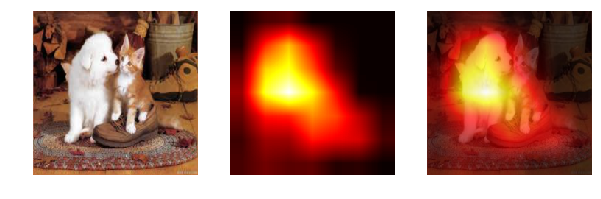

In [54]:
x = gradcam(resnet, image2, 207)

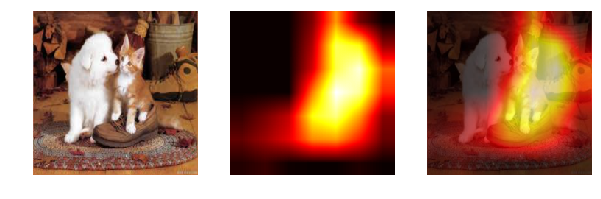

In [55]:
x = gradcam(resnet, image2, 281)

In [56]:
def gradcam_guided(model, input, label):
    gc = gradcam(model, input, label, plot=False)
    guided = saliency_map_guided(model, input, label, plot=False)
    gc = gc * guided
    
    rs = transforms.Resize((224,224))
    if isinstance(model, models.Inception3):
        rs = transforms.Resize((299,299))        
    input = rs(input)
    
    gc -= gc.min()
    gc = np.divide(gc, gc.max())
    gc *= 255
    gc = gc.astype(int)
    
    plt.rcParams["figure.figsize"] = (15,15)
    plt.subplot(1,3,1)
    plt.imshow(input)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.imshow(gc, cmap='hot')
    plt.subplot(1,3,3)
    plt.imshow(input)
    plt.imshow(gc, cmap='hot', alpha=0.7)
    plt.axis('off')
    
    return gc

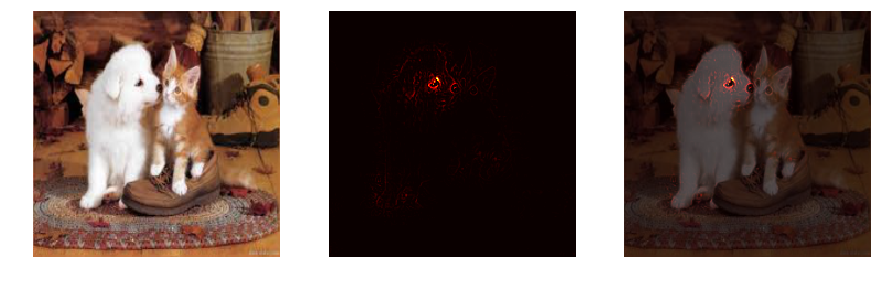

In [57]:
x = gradcam_guided(vgg, image2, 207)

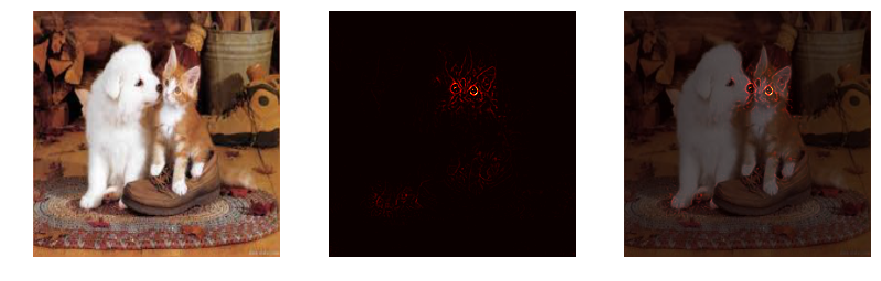

In [58]:
x = gradcam_guided(vgg, image2, 281)